### Upload kaggle.json to colab

In [12]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Allocate the required permission for this file

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

### Download and unzip data

In [14]:
! kaggle competitions download state-farm-distracted-driver-detection

100% 4.00G/4.00G [01:34<00:00, 83.7MB/s]
100% 4.00G/4.00G [01:34<00:00, 45.6MB/s]


In [ ]:
! unzip state-farm-distracted-driver-detection.zip

In [28]:
import os, csv

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from tensorflow.keras import regularizers
from tensorflow.keras.applications.xception import Xception

TRAIN_DIR = './imgs/train'
TEST_DIR = './imgs/test'

NUM_CLASSES = 10
IMG_SIZE = 299  # Xception was trained on (299,299,3) images


BATCH_SIZE = 32
NUM_EPOCH = 10
LEARNING_RATE = 5e-5
VALIDATION_SPLIT = 0.2
MODEL_NAME = 'Xception'
PRETRAIN_WEIGHTS = 'imagenet' # Can be 'imagenet' or None

In [6]:
def build_dataset():
    train_data = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, 
        label_mode='categorical', 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE,
        seed=0, # Needed when using validation split
        validation_split=VALIDATION_SPLIT,
        subset='training'
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, 
        label_mode='categorical', 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_split=VALIDATION_SPLIT,
        subset='validation'
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR, 
        labels=None, 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE, 
        shuffle=False # Sorts alphabetically by filename
    )

    return (train_data, val_data, test_data)

In [7]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomContrast(factor=0.1),
    ],
    name='img_augmentation',
)


### Loading Pretrained Model

In [32]:
#load pre trained Xception model
model = Xception(weights='imagenet',include_top=True)
#Summary of Xception Model
print(model.summary())

91897856/91884032 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [33]:

# def build_model(num_classes, weights=None):
#     inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#     x = img_augmentation(inputs)

#     if weights is None:
#       model = Xception(include_top=True, input_tensor=x, weights=None, classes=num_classes)
#     else:
#       # Using pretrained weights, so let's finetune the top layers
#       model = Xception(include_top=False, input_tensor=x, weights=weights, classes=num_classes)
#       model.trainable = False # Freeze layers

#       # Add top layers (not frozen)
#       x = layers.GlobalAveragePooling2D()(model.output)
#       x = layers.BatchNormalization()(x)
#       x = layers.Dropout(0.2)(x)
#       outputs = layers.Dense(num_classes, activation='softmax', name='prediction')(x)
      
#       model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#     model.compile(optimizer=optimizer, 
#                   loss='categorical_crossentropy', 
#                   metrics=['accuracy'])

#     return model

def build_model(num_classes, weights=None):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)

    if weights is None:
      model = Xception(include_top=True, input_tensor=x, weights=None, classes=num_classes)
    else:
      # Using pretrained weights, so let's finetune the top layers
      model = Xception(include_top=False, input_tensor=x, weights=weights)
      #model.trainable = False # Freeze layers

      # Add top layers (not frozen)
      x = layers.Flatten()(model.output)
      x = layers.Dense(512, activation='relu')(x)
      x = layers.Dropout(0.5)(x)
      x = layers.Dense(256, activation='relu')(x)
      outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.L2(0.005), name='prediction')(x)
      
      model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)

      # Freeze layers
      for i in range(70):
        model.layers[i].trainable = False
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [34]:
from google.colab import files

def save_output_csv(filename, y_pred):
  output_path = f'{filename}.csv'
  image_names = sorted([img_name for img_name in os.listdir(TEST_DIR)])

  with open(output_path, 'w', newline='') as f:
        writer = csv.writer(f)
        title_row = ['img'] + [f'c{i}' for i in range(NUM_CLASSES)]
        writer.writerow(title_row, )
        for i in range(len(image_names)):
            name = [image_names[i]]
            data = list(map(str, y_pred[i]))
            row = name + data
            writer.writerow(row)

  files.download(output_path)

In [35]:
train_data, val_data, test_data = build_dataset()

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.
Found 79726 files belonging to 1 classes.


In [40]:

model = build_model(NUM_CLASSES, weights=PRETRAIN_WEIGHTS)

history = model.fit(train_data, 
                    epochs=NUM_EPOCH, 
                    batch_size=BATCH_SIZE,
                    validation_data=val_data)

y_pred = model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)

save_output_csv(MODEL_NAME, y_pred)

Epoch 1/10
561/561 [==============================] - 197s 344ms/step - loss: 1.8634 - accuracy: 0.3603 - val_loss: 1.2983 - val_accuracy: 0.5821
Epoch 2/10
561/561 [==============================] - 179s 319ms/step - loss: 0.9698 - accuracy: 0.6973 - val_loss: 0.8812 - val_accuracy: 0.7183
Epoch 3/10
561/561 [==============================] - 179s 318ms/step - loss: 0.6183 - accuracy: 0.8187 - val_loss: 0.4308 - val_accuracy: 0.8840
Epoch 4/10
561/561 [==============================] - 179s 318ms/step - loss: 0.4443 - accuracy: 0.8804 - val_loss: 0.4850 - val_accuracy: 0.8653
Epoch 5/10
561/561 [==============================] - 179s 318ms/step - loss: 0.3633 - accuracy: 0.9083 - val_loss: 0.3865 - val_accuracy: 0.8898
Epoch 6/10
561/561 [==============================] - 179s 318ms/step - loss: 0.2928 - accuracy: 0.9310 - val_loss: 0.3390 - val_accuracy: 0.9108
Epoch 7/10
561/561 [==============================] - 179s 318ms/step - loss: 0.2627 - accuracy: 0.9392 - val_loss: 0.3100 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
print(model.summary())

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 299, 299, 3)  0           ['input_5[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['img_augmentation[3][0]']       
                                )                                                                 
                                                                                           

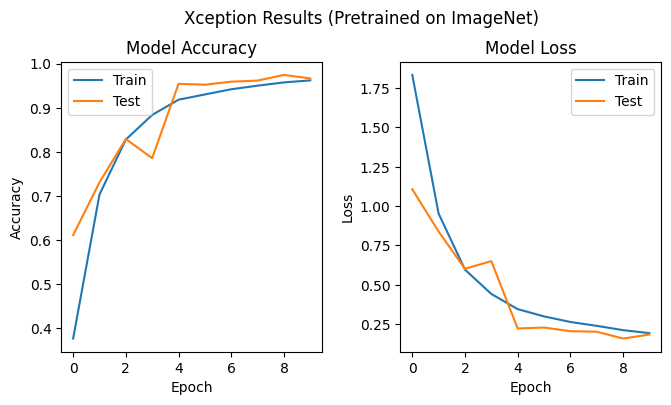

In [38]:
import matplotlib.pyplot as plt

def get_title():
  if PRETRAIN_WEIGHTS is None:
    weights_name = 'From Scratch'
  else:
    weights_name = 'Pretrained on ImageNet'
  return f'{MODEL_NAME} Results ({weights_name})'

def plot_accuracy(hist, ax):
  ax.plot(hist.history['accuracy'])
  ax.plot(hist.history['val_accuracy'])
  ax.set_title('Model Accuracy')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Test'], loc='upper left')


def plot_loss(hist, ax):
  ax.plot(hist.history['loss'])
  ax.plot(hist.history['val_loss'])
  ax.set_title('Model Loss')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Test'], loc='upper right')

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle(get_title())
plt.subplots_adjust(left=0, right=1, wspace=0.3, top=0.85)
fig.set_dpi(100)
plot_accuracy(history, ax1)
plot_loss(history, ax2)
plt.show()

In [20]:
def _get_training_class_path(driving_class: int = 0):
    """Gets the path to a specific class of the training images
    
    Args:
        driving_class (int): Class from 0 to 9 corresponding to the class of driving

    Returns:
        str: Path to the directory of images
    """
    if driving_class < 0 or driving_class > 9:
        return None
    class_folder_path = f'{TRAIN_DIR}/c{driving_class}/'
    return class_folder_path

In [21]:
def _get_training_class_paths():
    """
    Returns:
        list[str]: List of paths to the training class directories.
    """
    return [_get_training_class_path(id) for id in range(NUM_CLASSES)]

In [22]:
_get_training_class_path(0)

'./imgs/train/c0/'

In [26]:
_get_training_class_paths()

['./imgs/train/c0/',
 './imgs/train/c1/',
 './imgs/train/c2/',
 './imgs/train/c3/',
 './imgs/train/c4/',
 './imgs/train/c5/',
 './imgs/train/c6/',
 './imgs/train/c7/',
 './imgs/train/c8/',
 './imgs/train/c9/']

In [27]:
def get_training_image_paths_by_class():
    return [[f'{c}{i}' for i in os.listdir(c)] for c in _get_training_class_paths()]

In [29]:
img_paths = get_training_image_paths_by_class()

In [37]:
from PIL import Image
import numpy as np
def open_image_as_np(path_to_img: str):
    """
    Returns:
        np.array: Opened image
    """
    img = Image.open(path_to_img)
    img_as_np = np.asarray(img)
    return img_as_np

In [38]:
img = open_image_as_np(img_paths[0][0])

In [40]:
img.shape

(480, 640, 3)

In [42]:
img2 = Image.open(img_paths[0][0])

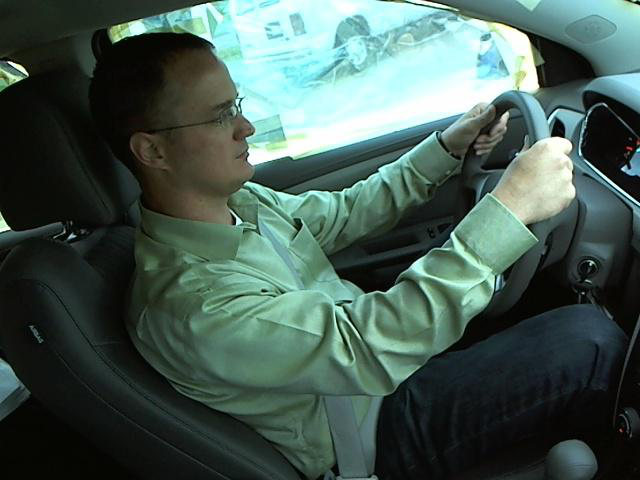

In [44]:
img2

In [45]:
img3 = img2.resize((299,299))

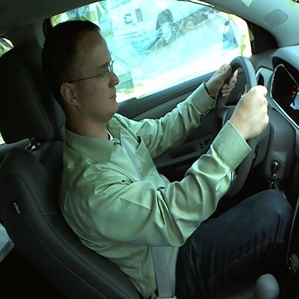

In [46]:
img3

In [41]:
 import matplotlib.pyplot as plt

In [ ]:
plt.imshow()

In [ ]:
import os, csv

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from tensorflow.keras.applications.resnet50 import ResNet50

TRAIN_DIR = './imgs/train'
TEST_DIR = './imgs/test'

NUM_CLASSES = 10
IMG_SIZE = 224  # EfficientNet was trained on (224,224,3) images
BATCH_SIZE = 64
NUM_EPOCH = 10
VALIDATION_SPLIT = 0.2
MODEL_NAME = 'ResNet50'